In [1]:
from collections import deque
from env.tsp_env import TspEnv
from utils import tsp_plots
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim

## Set parameters

In [2]:
NUMBER_OF_CITIES = 10
NUMBER_OF_NETS = 10

In [3]:
# Discount rate of future rewards
GAMMA = 0.99
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 100000
# Frequency of neural net 
BATCH_SIZE = 5
# Number of game steps to play before starting training
REPLAY_START_SIZE = 10000
# Exploration rate (episolon) is probability of choosing a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.001
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.9
# Number of steps between target network update
SYNC_TARGET_STEPS = 1000

In [4]:
# Set stopping conditions
MAXIMUM_RUNS = 50000
MAXIMUM_TIME_MINS =  480
NO_IMPROVEMENT_RUNS = 5000
NO_IMPROVEMENT_TIME = 120

In [5]:
# Set whether to plot all new best routes as they are found
PLOT_NEW_BEST_ROUTES = True

In [6]:
class DuellingDQN(nn.Module):

    """
    Deep Q Network solver. Includes control variables, memory of 
    state/action/reward/end, neural net,and methods to act, 
    remember, and update neural net by sampling from memory.
    """
    
    def __init__(self, observation_space, action_space, learning_rate):
        """Constructor method. Set up neural nets."""

        # Set up action space (choice of possible actions)
        self.action_space = action_space
              
        super(DuellingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(observation_space, observation_space * 4),
            nn.ReLU(),
            nn.Linear(observation_space * 4, observation_space * 4),
            nn.ReLU()
            )
        
        self.advantage = nn.Sequential(
            nn.Linear(observation_space * 4, observation_space * 4),
            nn.ReLU(),
            nn.Linear(observation_space * 4, action_space)
        )
        
        self.value = nn.Sequential(
            nn.Linear(observation_space * 4, observation_space * 4),
            nn.ReLU(),
            nn.Linear(observation_space * 4, 1)
        )
        
        # Set optimizer
        self.optimizer = optim.Adam(
                params=self.parameters(), lr=learning_rate)
        

    def act(self, state):

        q_values = self.forward(torch.FloatTensor(state))
        # Get index of action with best Q
        action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
        
  
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        action_q = value + advantage  - advantage.mean()
        return action_q

In [7]:
class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self, memory_size):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=memory_size)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [8]:
def optimize_duelling_dqn(policy_net, target_net, memory, batch_size, gamma):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < batch_size:
        return    
 
    # Sample a random batch from memory
    batch = random.sample(memory, batch_size)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get targen net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (gamma * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward

        # Update neural net
        
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [9]:
def main():
    """Main program loop"""
    
    print()
    
    # Set up environment
    time_start = time.time()
    env = TspEnv(number_of_cities = NUMBER_OF_CITIES, 
                 grid_dimensions = (100,100))
    
    exploration_rate = EXPLORATION_MAX
    
    # Get number of observations returned for state
    observation_space = env.observation_space.shape[0] * 2
    
    # Get number of actions possible
    n_actions = len(env.action_space)
    
    # Set up policy and target neural nets
    policy_nets = [DuellingDQN(observation_space, n_actions, LEARNING_RATE) for i in range(NUMBER_OF_NETS)]
    target_nets = [DuellingDQN(observation_space, n_actions, LEARNING_RATE) for i in range(NUMBER_OF_NETS)]
    
    # Copy weights from policy_net to target
    for i in range(NUMBER_OF_NETS):
        target_nets[i].load_state_dict(policy_nets[i].state_dict())
        # Set target net to eval rather than training mode
        # We do not train target net - ot is copied from policy net at intervals
        target_nets[i].eval() 
        
    # Set up a single memorymemomry
    memory = Memory(MEMORY_SIZE)
    
    # Set up list for results
    results_run = []
    results_exploration = []
    total_rewards = []
    best_reward = -999999
    best_route = None
    
    # Set run and time of last best route
    run_last_best = 0
    time_last_best = time.time()

    # Set up run counter and learning loop
    step = 0
    run = 0
    continue_learning = True
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        # Increment run (episode) counter
        run += 1
        total_reward = 0
        
        # Start run and get first state observations
        state, reward, terminal, info = env.reset()
        total_reward += reward
        
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
        
        # Reset route
        route = []
        
        # Episode loop
        while True:
            
            # Increment step counter
            step += 1
            
            # Pick action
            if random.random() < exploration_rate:
                # Explore by random action
                action = random.randrange(n_actions)
            else:
                # Pick action randomly from policy net results
                actions = [policy_nets[i].act(state) for i in range(NUMBER_OF_NETS)]
                random_index = random.randint(0, NUMBER_OF_NETS - 1)
                action = actions[random_index] 
            
            route.append(action)
            
            # Act
            state_next, reward, terminal, info = env.step(action)
            total_reward += reward
                     
            # Get observations for new state (s')
            state_next = np.reshape(state_next, [1, observation_space])
                        
            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            # Update neural net            
            
            if len(memory.memory) >= REPLAY_START_SIZE:
                # Update policy net 
                for i in range(NUMBER_OF_NETS):
                    optimize_duelling_dqn(policy_nets[i], target_nets[i], memory.memory, BATCH_SIZE, GAMMA)
                
                # Update the target network at intervals
                if step % SYNC_TARGET_STEPS == 0:
                    for i in range(NUMBER_OF_NETS):
                        target_nets[i].load_state_dict(policy_nets[i].state_dict())
        
                 
            # Actions to take if end of game episode
            if terminal:
                # Clear print row content
                clear_row = '\r' + ' '*100 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run: 5.0f}, ', end='')
                exp = exploration_rate
                print (f'exploration: {exp: 4.3f}, ', end='')
                print (f'total reward: {total_reward: 6.0f}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(exploration_rate)
                total_rewards.append(total_reward)

                # Check for best route so far
                if total_reward > best_reward:
                    best_reward = total_reward
                    best_route = route
                    run_last_best = run
                    time_last_best = time.time()
                    time_elapsed = (time.time() - time_start) / 60
                    print(f'\nNew best run. Run : {run: 5.0f},  ' \
                          f'Time {time_elapsed: 4.0f}  ' \
                          f'Reward {total_reward: 6.0f}')
                    # Plot new best route
                    if PLOT_NEW_BEST_ROUTES and step > REPLAY_START_SIZE:
                        if best_reward > 0:
                            tsp_plots.plot_route(env, best_route)
                            print()
                    
                # Adjust exploration rate
                if step > REPLAY_START_SIZE:
                    exploration_rate *= EXPLORATION_DECAY
                    exploration_rate = max(EXPLORATION_MIN, exploration_rate)
                    
 
                                
                # Check stopping conditions
                stop = False
                if step > REPLAY_START_SIZE:
                    if run == MAXIMUM_RUNS:
                        stop = True
                    elif time.time() - time_start > MAXIMUM_TIME_MINS * 60:
                        stop = True
                    elif time.time() - time_last_best > NO_IMPROVEMENT_TIME*60:
                        stop = True
                    elif run - run_last_best == NO_IMPROVEMENT_RUNS:
                        stop = True
                        
                if stop:
                    # End training
                    continue_learning = False
     
                # End episode
                break
            
    ############################# Plot results #################################
        
    # Plot result progress
    tsp_plots.plot_result_progress(total_rewards)
    
    # Plot best route
    tsp_plots.plot_route(env, best_route)
    
    ###################### Show route and distances ############################
    
    print ('Route')
    print (best_route)
    print ()
    print ('Best route distance')
    print (f'{env.state.calculate_distance(best_route):.0f}')


Run:     1, exploration:  1.000, total reward:  -1737                                               
New best run. Run :     1,  Time    0  Reward  -1737
Run:    12, exploration:  1.000, total reward:   -604                                               
New best run. Run :    12,  Time    0  Reward   -604
Run:   127, exploration:  1.000, total reward:   -534                                               
New best run. Run :   127,  Time    0  Reward   -534
Run:   129, exploration:  1.000, total reward:    220                                               
New best run. Run :   129,  Time    0  Reward    220
Run:   356, exploration:  0.001, total reward:    411                                               
New best run. Run :   356,  Time   22  Reward    411


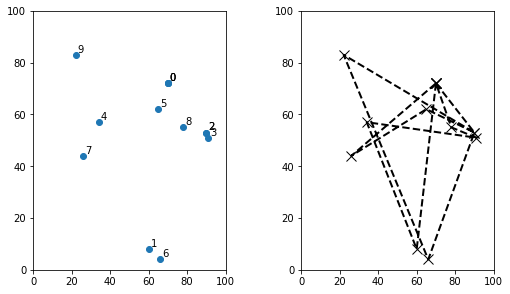


Run:   357, exploration:  0.001, total reward:    471                                               
New best run. Run :   357,  Time   23  Reward    471


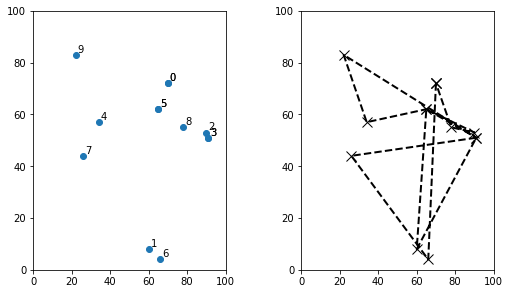


Run:   363, exploration:  0.001, total reward:    511                                               
New best run. Run :   363,  Time   23  Reward    511


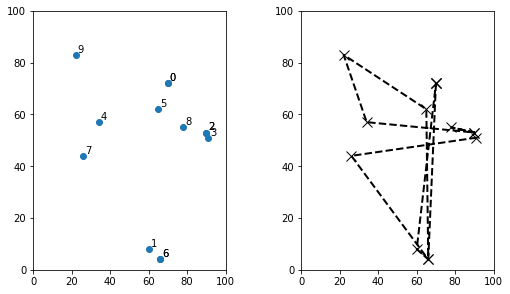


Run:   397, exploration:  0.001, total reward:    679                                               
New best run. Run :   397,  Time   26  Reward    679


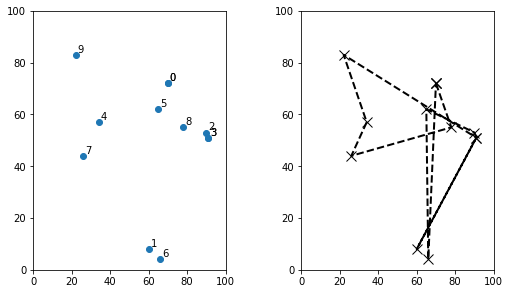


Run:   445, exploration:  0.001, total reward:    709                                               
New best run. Run :   445,  Time   30  Reward    709


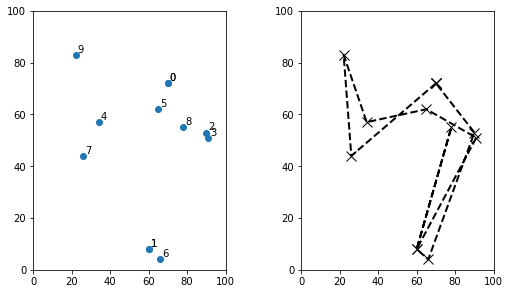


Run:   532, exploration:  0.001, total reward:    751                                               
New best run. Run :   532,  Time   35  Reward    751


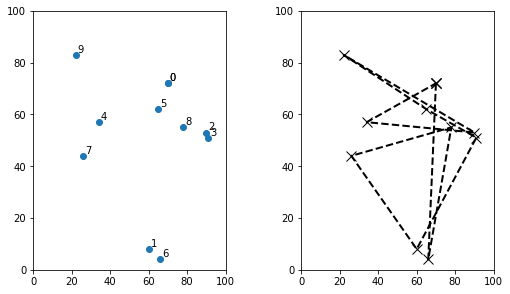


Run:   622, exploration:  0.001, total reward:    797                                               
New best run. Run :   622,  Time   38  Reward    797


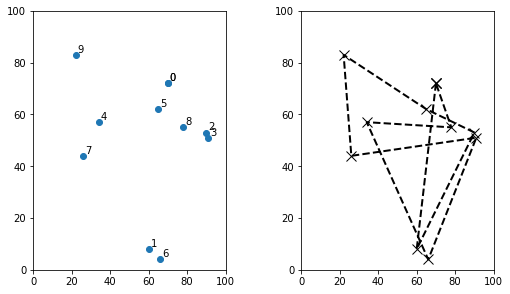


Run:   638, exploration:  0.001, total reward:    800                                               
New best run. Run :   638,  Time   39  Reward    800


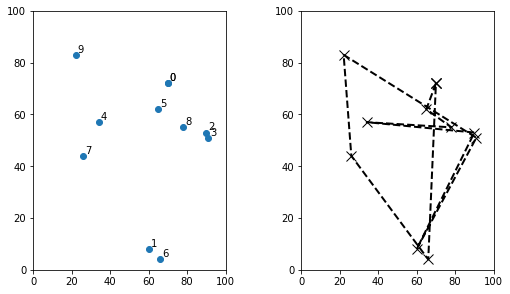


Run:   647, exploration:  0.001, total reward:    840                                               
New best run. Run :   647,  Time   39  Reward    840


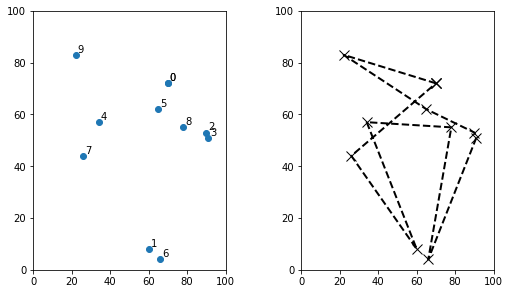


Run:   674, exploration:  0.001, total reward:    870                                               
New best run. Run :   674,  Time   40  Reward    870


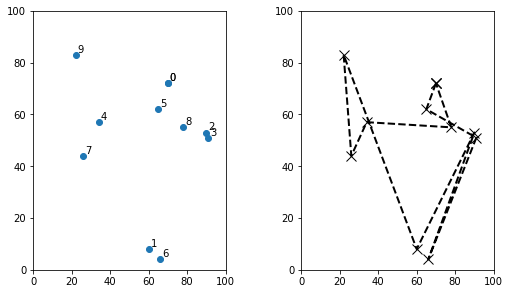


Run:   778, exploration:  0.001, total reward:    885                                               
New best run. Run :   778,  Time   43  Reward    885


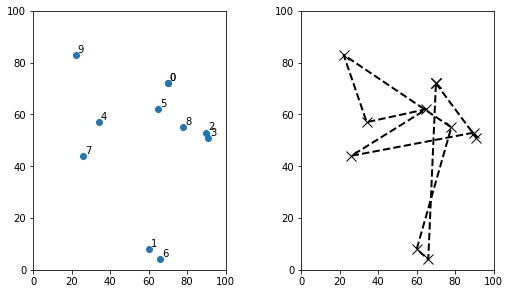


Run:   812, exploration:  0.001, total reward:    973                                               
New best run. Run :   812,  Time   45  Reward    973


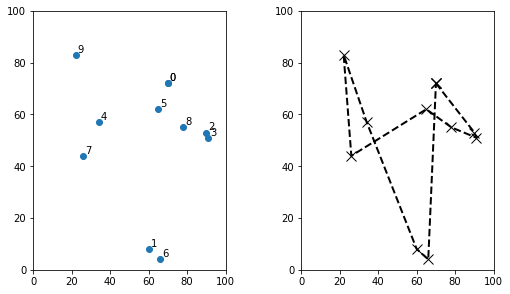


Run:  1402, exploration:  0.001, total reward:    974                                               
New best run. Run :  1402,  Time   62  Reward    974


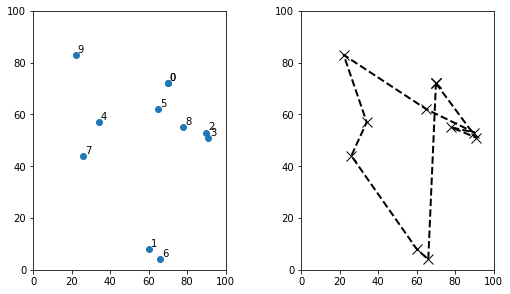


Run:  1769, exploration:  0.001, total reward:    982                                               
New best run. Run :  1769,  Time   70  Reward    982


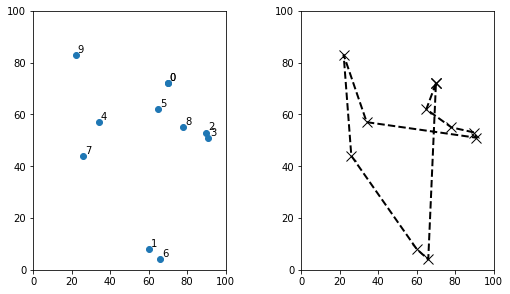


Run:  1808, exploration:  0.001, total reward:    991                                               
New best run. Run :  1808,  Time   71  Reward    991


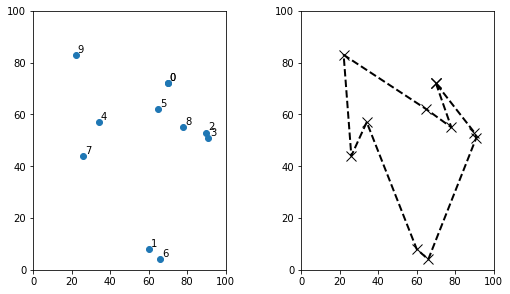


Run:  1820, exploration:  0.001, total reward:    997                                               
New best run. Run :  1820,  Time   71  Reward    997


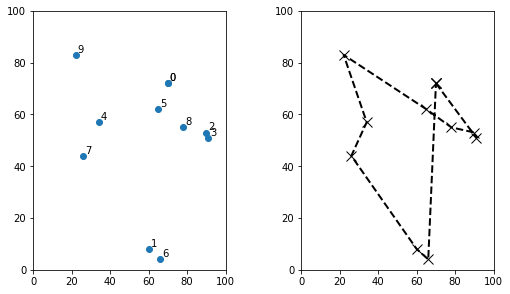


Run:  1917, exploration:  0.001, total reward:   1029                                               
New best run. Run :  1917,  Time   73  Reward   1029


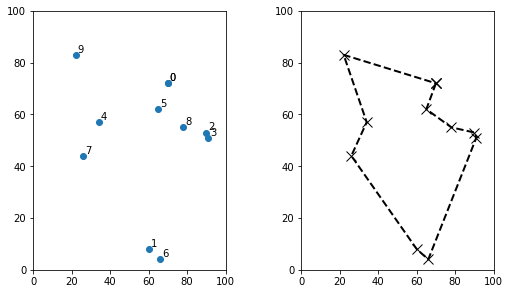


Run:  6917, exploration:  0.001, total reward:   1006                                               

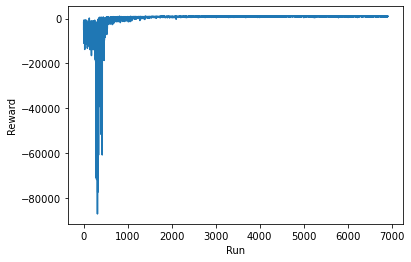

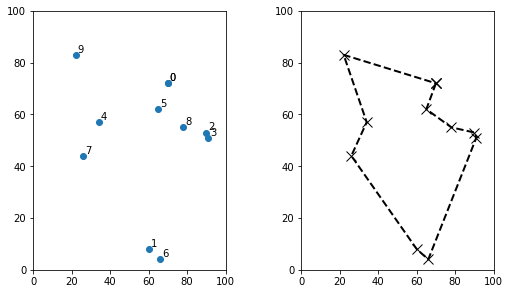

Route
[5, 8, 2, 3, 6, 1, 7, 4, 9, 0]

Best route distance
232


In [10]:
main()